In [0]:
import numpy as np
import pandas as pd
import json
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import model_from_json
import os
import csv


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMAGE PREPROCESSING

In [0]:
# !apt install unzip
# !unzip "/content/drive/My Drive/MoreImages.zip" -d "/content/drive/My Drive/IMAGES2"

In [0]:
# !apt install unzip
# !unzip "/content/drive/My Drive/images.zip" -d "/content/drive/My Drive/IMAGES2"

In [0]:
# image_info loading
with open("/content/drive/My Drive/Copy of images_info.json") as json_file:
  images_info = json.load(json_file)

In [0]:
df_images_info = pd.DataFrame(images_info)
del(images_info)
df_images_info.head(10)


,file_name,height,width,id
0,000000397133.jpg,427,640,397133
1,000000037777.jpg,230,352,37777
2,000000252219.jpg,428,640,252219
3,000000087038.jpg,480,640,87038
4,000000174482.jpg,388,640,174482
5,000000403385.jpg,511,640,403385
6,000000006818.jpg,640,427,6818
7,000000480985.jpg,500,375,480985
8,000000458054.jpg,426,640,458054
9,000000331352.jpg,500,351,331352


In [0]:
df_images_info.loc[df_images_info.id==285, 'file_name'].values[0]

'000000000285.jpg'

In [0]:
# additional_image_info loading
with open("/content/drive/My Drive/Copy of additional_images_info.json") as json_file:
  additional_images_info = json.load(json_file)

In [0]:
df_additional_images_info = pd.DataFrame(additional_images_info)
del(additional_images_info)
df_additional_images_info.head(10)

,file_name,height,width,id
0,000000333845.jpg,486,640,333845
1,000000553401.jpg,427,640,553401
2,000000208623.jpg,386,640,208623
3,000000350389.jpg,480,640,350389
4,000000324580.jpg,640,480,324580
5,000000223203.jpg,640,533,223203
6,000000152628.jpg,640,462,152628
7,000000239728.jpg,427,640,239728
8,000000413999.jpg,428,640,413999
9,000000371608.jpg,480,640,371608


In [0]:
df_images_info[df_images_info['file_name']=='000000333845.jpg']['id']


Series([], Name: id, dtype: int64)

In [0]:
len(df_images_info)

5000

In [0]:
frames = [df_images_info, df_additional_images_info]
df_images_info = pd.concat(frames, ignore_index=True)
del(df_additional_images_info)
len(df_images_info)


15000

In [0]:
# Loading labels
with open("/content/drive/My Drive/Copy of labels_with_bbox.json") as json_file:
  labels1 = json.load(json_file)

df_labels = pd.DataFrame(labels1)
df_labels.head(10)
del(labels1)


In [0]:
with open("/content/drive/My Drive/Copy of additional_labels.json") as json_file:
  additional_labels = json.load(json_file)

df_additional_labels = pd.DataFrame(additional_labels)
del(additional_labels)
df_additional_labels.head(10)

,image_id,bbox,category_id
0,495357,"[337.02, 244.46, 66.47, 66.75]",18
1,16164,"[324.66, 247.92, 250.87, 181.02]",18
2,370210,"[170.47, 179.11, 147.58, 319.8]",18
3,32054,"[184.54, 338.14, 176.11, 295.08]",18
4,145544,"[328.95, 176.93, 310.05, 247.35]",18
5,278550,"[12.47, 82.61, 107.86, 62.35]",18
6,546642,"[246.39, 169.19, 111.45, 80.56]",18
7,106166,"[372.2, 205.54, 76.05, 82.66]",18
8,135275,"[337.44, 182.24, 68.16, 56.63]",18
9,162256,"[91.8, 302.55, 333.57, 337.45]",18


In [0]:
frames = [df_labels, df_additional_labels]
df_labels = pd.concat(frames, ignore_index=True)
del(df_additional_labels)

len(df_labels)

110047

In [0]:
group = df_labels.groupby('image_id')

df2 = group.apply(lambda x: x['category_id'].unique())

df2.head(10)


image_id
72                                        [25]
73                                         [4]
109                                [18, 1, 15]
133                                   [65, 88]
139    [64, 72, 62, 1, 78, 82, 84, 85, 86, 67]
201                                    [36, 1]
285                                       [23]
474                                    [1, 40]
486                       [82, 79, 44, 49, 51]
542                             [5, 1, 31, 32]
dtype: object

In [0]:
df2[df2.index[2]]

array([18,  1, 15])

## Loading Images

In [0]:
# Parameters
TARGET_SIZE = 224

In [0]:
images_arr = np.zeros([15000, TARGET_SIZE, TARGET_SIZE, 3], dtype='float32')

In [0]:
with ZipFile('/content/drive/My Drive/Copy of images.zip', 'r') as zipfile:
  infolist = zipfile.infolist()
  infolist = [infolist[i] for i in range(1, len(infolist)) if i%2==0]
  filename_arr = []
  for i, info in enumerate(infolist):
    filename_arr.append(info.filename[8:])
    img = Image.open(zipfile.open(info))
    img = img.resize((TARGET_SIZE, TARGET_SIZE))
    img = img.convert('RGB')
    img = np.asarray(img).astype('float32')
    images_arr[i] = img
i = i + 1

In [0]:
with ZipFile('/content/drive/My Drive/Copy of MoreImages.zip', 'r') as zipfile:
  infolist1 = zipfile.infolist()[1:]
  filename1_arr = []
  for j, info in enumerate(infolist1):
    filename1_arr.append(info.filename[11:])
    img = Image.open(zipfile.open(info))
    img = img.resize((TARGET_SIZE, TARGET_SIZE))
    img = img.convert('RGB')
    img = np.asarray(img).astype('float32')
    images_arr[i+j] = img

In [0]:
filename_arr = filename_arr + filename1_arr
del(filename1_arr)

In [0]:
del(infolist)
del(infolist1)

In [0]:
len(filename_arr)

15000

In [0]:
len(df_images_info.file_name.unique())

15000

In [0]:
df_images_info.loc[df_images_info['file_name']=='000000182611.jpg']

,file_name,height,width,id
3327,000000182611.jpg,640,480,182611


In [0]:
filename_arr.index('000000182611.jpg')

0

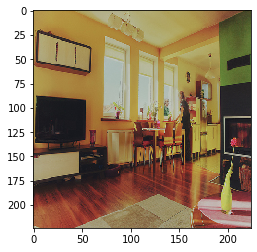

In [0]:
# plt.plot(images_arr[0])
plt.imshow(images_arr[1792]/255)

In [0]:
with open("/content/drive/My Drive/categories_info.json") as json_file:
  categories_info = json.load(json_file)

df_categories_info = pd.DataFrame(categories_info)
del(categories_info)
df_categories_info.head()
df_categories_info.id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90])

In [0]:
df_labels.category_id.unique()

array([18, 64, 72, 16, 17, 19, 20, 21, 44, 63, 62, 67,  2,  3,  4,  5,  6,
        7,  9,  1, 13, 28, 32, 54, 65, 77, 82, 85, 90,  8, 10, 11, 14, 15,
       34, 35, 36, 41, 42, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59,
       61, 70, 73, 74, 75, 76, 78, 79, 80, 81, 84, 86, 87, 88, 89, 27, 31,
       33, 22, 24, 38, 58, 60, 25, 39, 40, 37, 23, 43])

In [0]:
len(df_labels.category_id.unique())

80

In [0]:
df_labels.loc[df_labels['image_id']==139]

,image_id,bbox,category_id
24394,139,"[236.98, 142.51, 24.7, 69.5]",64
24452,139,"[7.03, 167.76, 149.32, 94.87]",72
24458,139,"[557.21, 209.19, 81.35, 78.73]",72
24556,139,"[358.98, 218.05, 56.0, 102.83]",62
24568,139,"[290.69, 218.0, 61.83, 98.48]",62
24577,139,"[413.2, 223.01, 30.17, 81.36]",62
24602,139,"[317.4, 219.24, 21.58, 11.59]",62
24772,139,"[412.8, 157.61, 53.05, 138.01]",1
24776,139,"[384.43, 172.21, 15.12, 35.74]",1
27311,139,"[512.22, 205.75, 14.74, 15.97]",78


As some images haven't got corresponding label
 we should delete them.

In [0]:

no_label_img = []
img_ids = df_images_info.id.unique()
label_img_ids = df_labels.image_id.unique()
for img_id in img_ids:
  if img_id not in label_img_ids:
    no_label_img.append(img_id)
img_names = []

for i in range(len(no_label_img)):
  x = no_label_img[i]
  y = list(df_images_info.loc[df_images_info.id == x,'file_name'])
  y = y[0]
  # print(y)
  img_names.append(y)


for j in range(len(img_names)):
  x = img_names[j]
  print(j)
  i = int(filename_arr.index(x))
  images_arr = np.delete(images_arr, i, 0)
  filename_arr.remove(x)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132


# One-Hot label for each image

In [0]:
# Encoding

data = np.array(df_labels["category_id"])
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
le_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
ld_dict = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(integer_encoded[0])
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded[0])

inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
print(inverted)

[18 18 18 ...  1  1  1]
16
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[18]


In [0]:
print(ld_dict.items())

dict_items([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 13), (12, 14), (13, 15), (14, 16), (15, 17), (16, 18), (17, 19), (18, 20), (19, 21), (20, 22), (21, 23), (22, 24), (23, 25), (24, 27), (25, 28), (26, 31), (27, 32), (28, 33), (29, 34), (30, 35), (31, 36), (32, 37), (33, 38), (34, 39), (35, 40), (36, 41), (37, 42), (38, 43), (39, 44), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 67), (61, 70), (62, 72), (63, 73), (64, 74), (65, 75), (66, 76), (67, 77), (68, 78), (69, 79), (70, 80), (71, 81), (72, 82), (73, 84), (74, 85), (75, 86), (76, 87), (77, 88), (78, 89), (79, 90)])


In [0]:
# save dictionary
# Save

np.save('/content/drive/My Drive/my_file.npy', ld_dict) 

In [0]:
labels = np.zeros((len(df2), 80))
image_id = np.zeros((len(df2), 1), dtype='uint8')

 
for i in range(len(df2.index)):
  temp = np.zeros((1, 80))
  # image_id[i] = df2.index[i]
  
  for k in df2[df2.index[i]]:
    place = le_dict[k]
    labels[i, place] = 1
    # temp = temp + onehot_encoded[place, :]  
    # one_hot_labels[i, k-1] = 1
  # for j in range 
  # labels[i] = temp
# image_id[4952: ] = image_id[0:48]

In [0]:
print(le_dict[15])
labels[2]

13


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
print(le_dict[18])

16


In [0]:
onehot_labels = np.zeros((len(df2), 80))
df2_list = list(df2.index)

for i in range(len(filename_arr)):
  x = filename_arr[i]
  y = list(df_images_info.loc[df_images_info.file_name == x,'id'])
  y = y[0]    # image_id

  idx = df2_list.index(y)
  # print(idx)
  onehot_labels[i] = labels[idx]    # Final Labels

## Train and Test Dataset & Data Augmentation

In [0]:
images_arr = preprocess_input(images_arr)

In [0]:
x_train = images_arr[:13000]
y_train = onehot_labels[:13000]

x_test = images_arr[13000:]
y_test = onehot_labels[13000:]

In [0]:
# Data Augmentation

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)


# MODEL

In [0]:
base_model = InceptionV3(input_shape=(TARGET_SIZE, TARGET_SIZE, 3), include_top=False, weights='imagenet')














87916544/87910968 [==============================] - 6s 0us/step


In [0]:
base_model.trainable = False

## Add some trainable dense layers

In [0]:
out1 = base_model.output
# Global Averaging Pooling
out_pooling = GlobalAveragePooling2D()(out1)
# Feature Layer
feature_layer = Dense(1024, activation='relu')(out_pooling)
# Output Layer
output_layer = Dense(80, activation='sigmoid')(feature_layer)


model = Model(inputs=base_model.input, outputs=output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Training Model

In [0]:
# Hyper Parameters:
batch_size = 128
lr = 0.001
num_epoch = 10

In [0]:
model.compile(optimizer=RMSprop(lr=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=num_epoch, verbose=1, validation_data=(x_test, y_test))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
102/101 [==============================] - 140s 1s/step - loss: 0.1546 - acc: 0.9595 - val_loss: 0.1355 - val_acc: 0.9624
Epoch 2/10
102/101 [==============================] - 118s 1s/step - loss: 0.1253 - acc: 0.9649 - val_loss: 0.1927 - val_acc: 0.9649
Epoch 3/10
102/101 [==============================] - 120s 1s/step - loss: 0.1137 - acc: 0.9663 - val_loss: 0.1799 - val_acc: 0.9610
Epoch 4/10
102/101 [==============================] - 120s 1s/step - loss: 0.1066 - acc: 0.9672 - val_loss: 0.1828 - val_acc: 0.9639
Epoch 5/10
102/101 [==============================] - 119s 1s/step - loss: 0.1017 - acc: 0.9680 - val_loss: 0.1466 - val_acc: 0.9647
Epoch 6/10
102/101 [==============================] - 119s 1s/step - loss: 0.0980 - acc: 0.9687 - val_loss: 0.1274 - val_acc: 0.9659
Epoch 7/10
102/101 [==============================] - 119s 1s/step - loss: 0.0946 - acc: 0.9693 - val_lo

In [0]:
# features of train data:
layer_name = 'dense_1'
model1 = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
feature_map = model1.predict(images_arr)

In [0]:
History = model.evaluate(x_test, y_test)
History

1867/1867 [==============================] - 4s 2ms/step


[0.10144530045168887, 0.9690278603804577]

In [0]:
model.save("/content/drive/My Drive/model.h5")


In [0]:
model.save_weights('/content/drive/My Drive/weights.h5',overwrite=True)